# Run Recommender System on dose-dependent Phospho-Proteomics Data

### Packages that are necessary (install via pip install "package-name")
    -numpy
    -pandas
    -seaborn
    -anndata
    -scipy
    -scanpy
    -scvelo
    -statsmodels
    -matplotlib
    -tensorflow
    -sklearn
    -plotly (for interactive plots in jupyter lab)
    
### To run the full script, approximately 40Gb or RAM and preferably a GPU are needed (1.5 Gb GPU memory is enough)

# Load the paths

### To avoid vulnerabilty to hacking, all the paths need to be provided by the user. For KusterLab, you can get the paths from me, just ask via manuelgander1@gmail.com

### Otherwise either define the paths now:

In [3]:
# Path to the toml_files of the experiment
toml_path=''

# Path to the pandas-DataFrames where curve fitting has already been performed
DataFrames_path=''

# Mathews psite_annotation package can be access via GitLAB
psite_annotation_path=''

# Path to save intermediary results
Path=''

# Specify there path were to find the regulation matrix:
matrix_path=''

# Path to the dictionaries, which is stuff like KEGG pathways, drug targets, Kinobead data, ...
# I'm not allowed to upload them either, so I send them upon request: manuelgander1@gmail.com
Dictionary_path=''

# Path to where "Recommender_System_Proteomics" is saved
path_to_repository=''

### or define them later (they will be mentioned at the places where they are needed)

In [5]:
# Import packages and scripts

import anndata
import numpy as np

import psite_recommender

from psite_recommender import extract_from_raw_data as extr
from psite_recommender import preprocessing as pp
from psite_recommender import recommender_system as rs
from psite_recommender import curve_inspection as ci
from psite_recommender import embedding as emb 
from psite_recommender import heatmaps as hm

# Load the data

The input of this script must be one out of two things (has to follow TOPAS data format):
   - the data frames where curve fitting was performed (as in /TOPAS.../7__results)
   - a regulation matrix (as in /TOPAS.../10__analysis)

## If Data frames as input:

In [ ]:
# Path to the toml_files of the experiments
toml_path=''

# Path to the pandas-DataFrames where curve fitting has already been performed
DataFrames_path=''

In [ ]:
# Takes about 2h, 25 min
matrix, Data, Df, Dfz=extr.extract_and_refine_regualtion(toml_path, DataFrames_path, 
                                                     fc_lim=0.55, alpha=0.015, pick_criterion='Andromeda Score')

### Potenially safe / load intermediary results

To free RAM, I recommend saving, restarting the kernel and then reloading the data

In [22]:
# Saving
matrix.write(f'{Path}/regulation_matrix.h5ad')
np.save(f'{Path}/Data.npy', Data)

In [ ]:
# Loading
matrix=anndata.read(filename=f'{Path}/regulation_matrix.h5ad')

Data=np.load(f'{Path}/Data.npy', allow_pickle=True)
Data=dict(enumerate(Data.flatten()))[0]

In [8]:
matrix=anndata.read(filename=f'{Path}/regulation_matrix.h5ad')

## If Regulation matrix as input

In [19]:
# Specify there path were to find the regulation matrix:
path=''

# And load it
matrix=pp.load_matrix(matrix_path)

# Preprocessing

In [ ]:
# Download Matthews p_site annotions via GitLab. Here you have to provide tha path to where you saved it

psite_annotation_path=''

In [7]:
# Path to save intermediary results
Path='/home/mgander/Phos/Data'
matrix=anndata.read(filename=f'{Path}/regulation_matrix_unprocessed.h5ad')

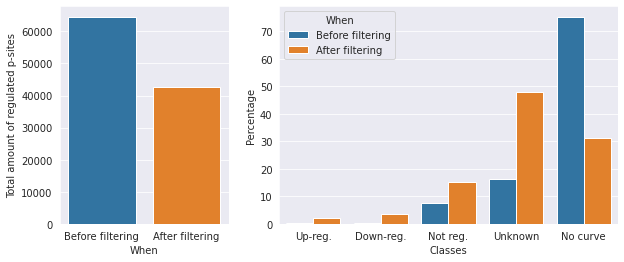

In [9]:
# Performs filtering and adds additional information (like phosphosite-annotations) needed later on
matrix=pp.preprocess(matrix, Dictionary_path, psite_annotation_path, min_reg_phos=10, min_reg_pept=3)

# Run the Recommender Systems

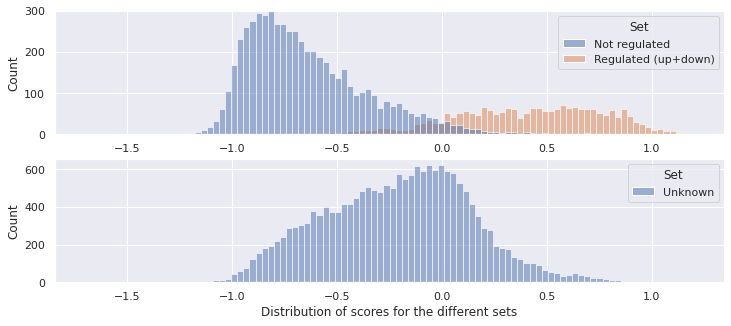

In [15]:
# Run ALS
matrix=rs.run_weighted_ALS(matrix, variant='up+down', test_set_ratio=0.05, dims=20, regularization=10, 
                     iterations=50, weight_empty=0.01, weight_unknown=0.01)

2022-11-25 09:48:40.586362: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-25 09:48:41.219269: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1024 MB memory:  -> device: 0, name: NVIDIA TITAN Xp, pci bus id: 0000:af:00.0, compute capability: 6.1


16521/16521 [==============================] - 73s 4ms/step


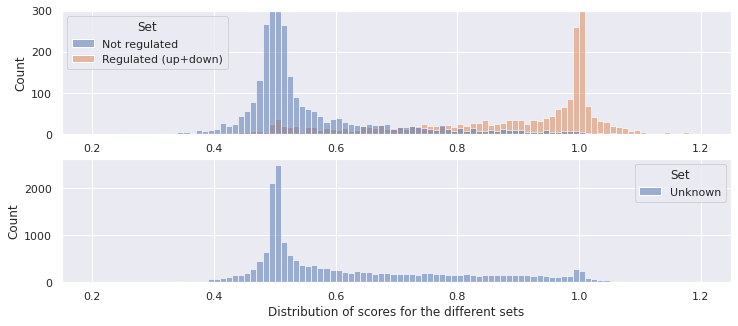

In [16]:
# Run NN-based approach
matrix, model=rs.run_NN_RS(matrix, variant='up+down', test_set_ratio=0.05, epochs=3*10**2,
                           dim0=20, dim1=5, dim_dl=3, dim_features=2, dim_dl_and_features=3)

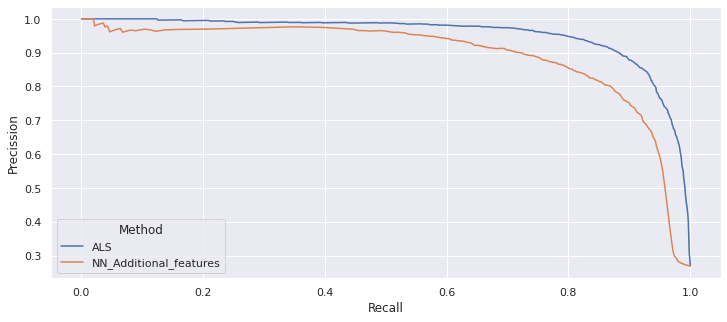

In [17]:
# Plot the two precision-recall-curves
dfc=rs.plot_precision_recall_comparison(matrix)

# Recommend curves

55.2% of recommended curves (2061 curves) satisfy the more leniant leniant classification criteria


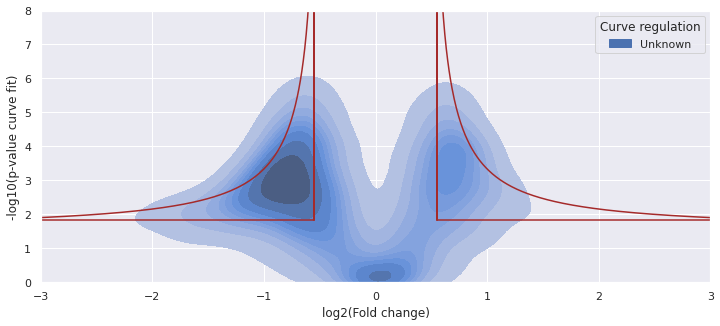

In [20]:
# Depending on "min_precision", this may take a while... (approx. 2-40 min)

Dfr=ci.recommend_curves(matrix, Data, min_precision=0.99)

# Inspect the embeddings

In [21]:
# Calcualte UMAPS
matrix=emb.calc_umaps(matrix, neighbors_drugs=5, neighbors_peptides=20)

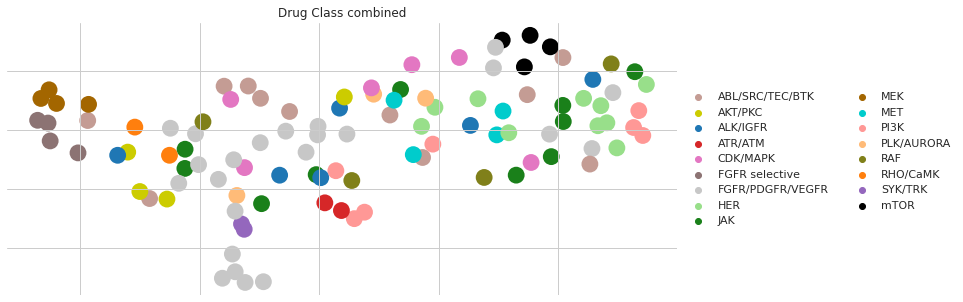

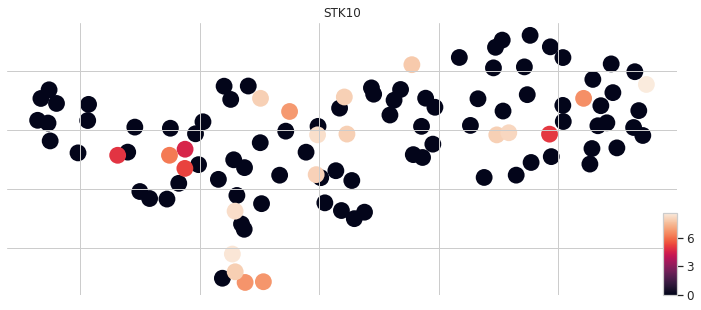

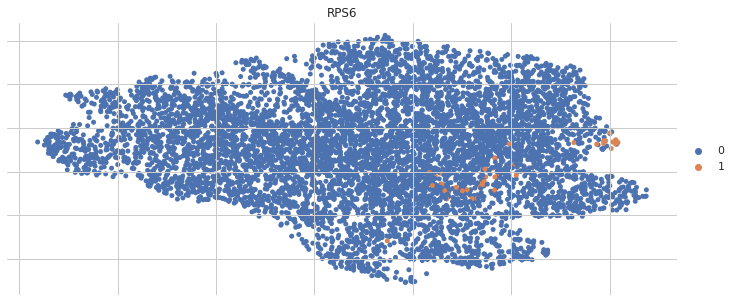

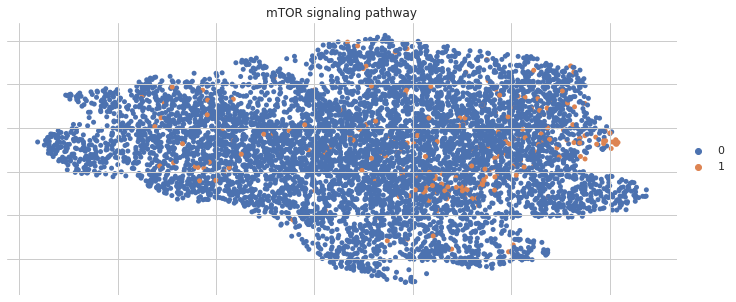

In [22]:
# Right now, 4 different visualization are implemented:


# Two for the drug-embedding:

# Plots drugs based on their target kinases, where these classes are colored based on phylogenetic distance
emb.plot_drug_umap(matrix, Dictionary_path, color_key='Drug Class combined', interactive=False)

# Plots drugs based on there affinity in the kinobead experiment (color as 1 is affinity is above 1000 nM)
emb.plot_kinobead_umap(matrix, color_key='STK10', interactive=False)


# Two for the peptide-embedding:

# Plots all peptides of a specific gene
emb.plot_peptide_umap(matrix, color_key='RPS6', interactive=False)

# Plots peptides based on if they are known to be involved in a KEGG pathway
emb.plot_KEGG_umap(matrix, color_key='mTOR signaling pathway', interactive=False)

# Calculate heat maps

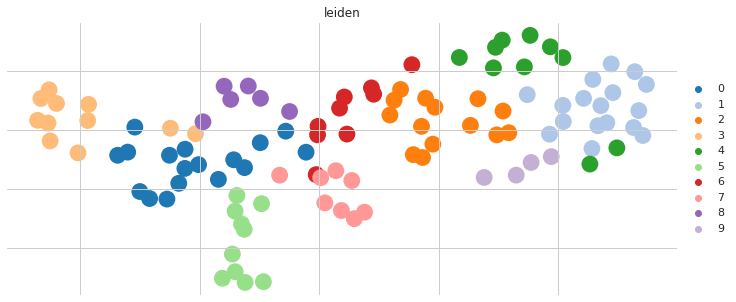

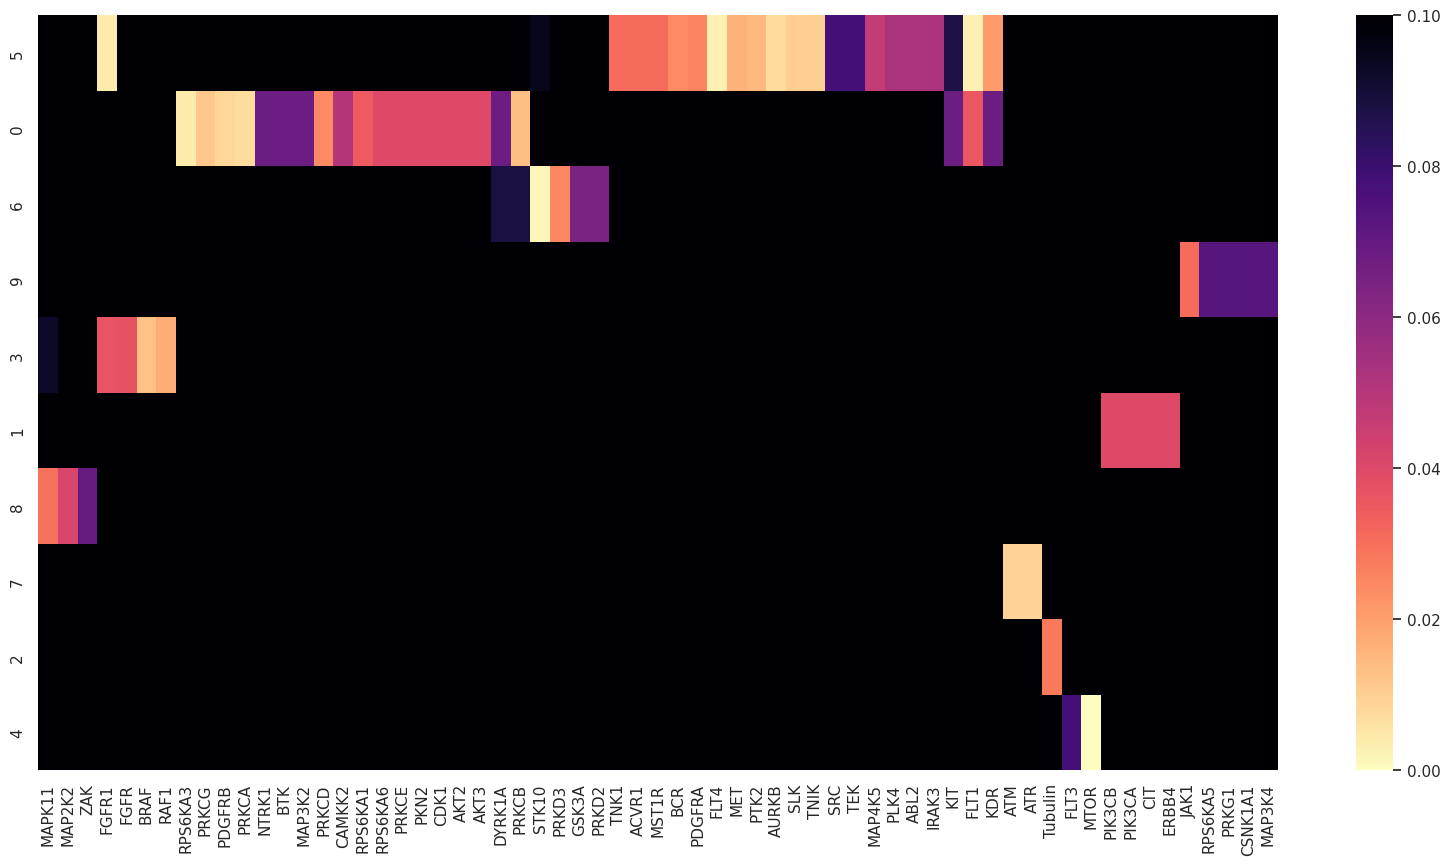

In [25]:
# For the drugs (based pn Kinobead-affinity)
matrix=hm.calculate_leiden_drugs(matrix, resolution=1.5)
Pdf=hm.calc_drug_heatmap(matrix, clustering='Leiden', cutoff=0.1)

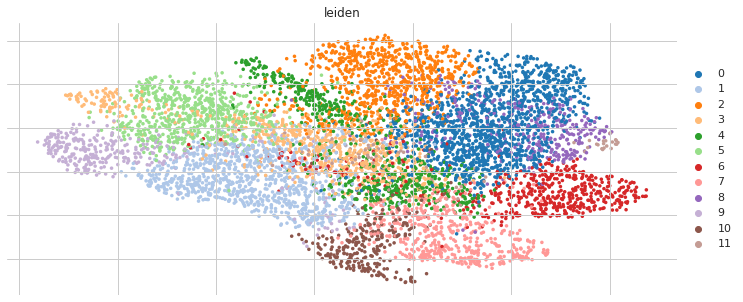

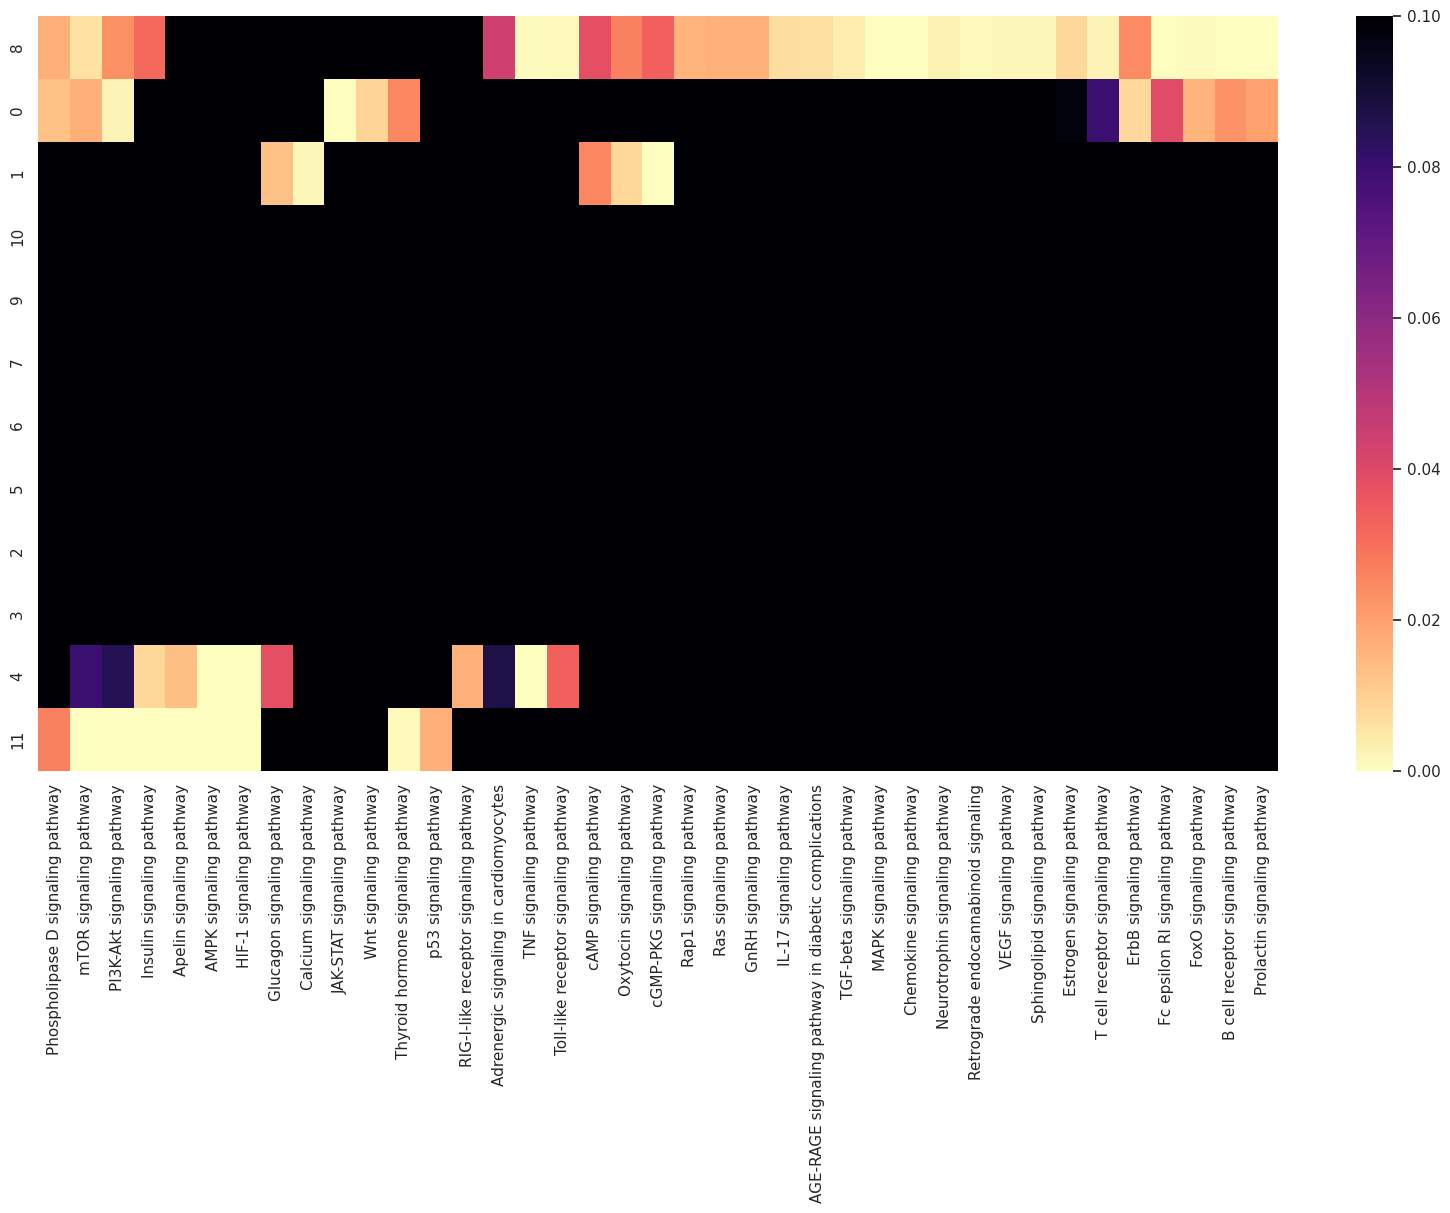

In [26]:
# For the peptides (based on KEGG-annotation):
matrix=hm.calculate_leiden_peptides(matrix, resolution=0.7)
Pdf=hm.calc_peptide_heatmap(matrix, clustering='Leiden', signaling_only=True, cutoff=0.1)